## Semi-supervised Image Classification using K-means Pseudo-labelling on MNIST

## Abstract

This project examines the integration of unlabeled data into semi-supervised learning frameworks using pseudo-labeling, through unsupervised K-Means clustering on the MNIST dataset. By employing various data augmentation techniques such as cropping, rotation, introduction of adversarial images such as Gaussian noise, and blur, the study aims to assess the model's resilience to data irregularities. The approach centers on a convolutional neural network (CNN) that initially trains on a subset of labeled data. This CNN is then used to extract deep features from subsets of both labeled and unlabeled training datasets.

These features guide the K-Means clustering of both labeled and unlabeled data, introducing a clustering loss aligned with the true labels. This enables the assignment of pseudo-labels to the unlabeled data. The full dataset, now enhanced with pseudo-labels, trains the CNN further, with the final model being tested for accuracy and image classification capabilities on a separate test set. The performance of the aforementioned method is then compared across varying scenarios where the number of labeled data points progressively decreases. This helps demonstrate a practical use of unlabeled data and the robustness of the learning model against augmentations for which it was not trained. The layout of the semi-supervised learning framework is illustrated in Figure 1.

<img src="./images/semi-supervised.png">

## Code Libraries

Used $numpy$ for multi dimensional arrays manipulation and data processing

Used $matplotlib$ for plotting and visualization

Used $pytorch$ for used for neural network training and optimization.

Used $torchvision$ for transforming dataset and loading MNIST dataset.

Used $Kmeans$ for clustering unlabeled dataset and $KNeighborsClassifier$ for aggregate labelling unlabeled cluster using labels from labeled dataset.

Used $Scipy$ $cdist$ for computing distance between points.


## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split


import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import cdist

In [2]:
## Global Variables
BATCH_SIZE = 64
EPOCHS = 4
LEARNING_RATE = 0.001
USE_GPU = True

In [3]:
## Model
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
      super(VGG16, self).__init__()

      self.layer1 = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.layer2 = nn.Sequential(
          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.layer3 = nn.Sequential(
          nn.Conv2d(128, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.layer4 = nn.Sequential(
          nn.Conv2d(256, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.layer5 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.classifier = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(512, 4096),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Linear(4096, num_classes)
      )

    def cnn(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.layer5(x)
      x = x.view(x.size(0), -1)
      return x

    def forward(self, x):
      x = self.cnn(x)
      x = self.classifier(x)
      return x

In [4]:
## Transformations

# Basic transformation setup
basic_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])

# Augmentation with Gaussian noise addition
noise_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda img: img + torch.randn(img.size()) * 0.1)
])

# Augmentation with rotation
rotation_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor()
])

# Augmentation with Gaussian blur
blur_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor()
])

In [5]:
def get_train_sets(labeled_ratio):
  trainset = MNIST(root='./data', train=True, download=True, transform=basic_transform)
  trainset_rotation = MNIST(root='./data', train=True, download=True, transform=rotation_augmentation)
  trainset_blur = MNIST(root='./data', train=True, download=True, transform=blur_augmentation)

  trainset = torch.utils.data.ConcatDataset([trainset, trainset_blur, trainset_rotation])

  trainset, _ = random_split(trainset, [30000, len(trainset) - 30000])

  # Split Dataset
  trainset_labeled, trainset_unlabeled = random_split(trainset, [int(labeled_ratio * len(trainset)), len(trainset) - int(labeled_ratio * len(trainset))])

  # Load Train Sets
  train_labeled_loader = torch.utils.data.DataLoader(trainset_labeled, batch_size=BATCH_SIZE, shuffle=True)
  train_unlabeled_loader = torch.utils.data.DataLoader(trainset_unlabeled, batch_size=BATCH_SIZE, shuffle=True)

  return train_labeled_loader, train_unlabeled_loader

In [6]:
def get_test_sets():
  # Test Sets
  testset = MNIST(root='./data', train=False, download=True, transform=basic_transform)
  testset_noise = MNIST(root='./data', train=False, download=True, transform=noise_augmentation)
  testset_rotation = MNIST(root='./data', train=False, download=True, transform=rotation_augmentation)
  testset_blur = MNIST(root='./data', train=False, download=True, transform=blur_augmentation)

  testset = torch.utils.data.ConcatDataset([testset, testset_noise, testset_rotation, testset_blur])
  testset, _ = random_split(testset, [20000, len(testset) - 20000])

  # Load Test Sets
  test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

  return test_loader

In [7]:
## Train
def train(train_loader, net, criterion, optimizer):
  net.train()
  main_loss = 0.0
  correct_predictions = 0
  loss_graph = []
  total_samples = 0

  for _, data in enumerate(train_loader):
      inputs, masks = data

      if USE_GPU:
          inputs, masks, net = inputs.cuda(), masks.cuda(), net.cuda()

      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()

      preds = torch.argmax(outputs, dim=1)

      correct_predictions += (preds == masks).sum().item()

      total_samples += masks.size(0)

      main_loss += loss.item()
      loss_graph.append(loss.item())

  avg_loss = main_loss / len(train_loader)
  accuracy = correct_predictions / total_samples * 100

  return avg_loss, accuracy, loss_graph

In [8]:
## Validate
def validate(val_loader, net, criterion):
  net.eval()
  val_loss = 0.0
  total_samples = 0
  correct_predictions = 0

  with torch.no_grad():
    for _, data in enumerate(val_loader):
      inputs, masks = data
      if USE_GPU:
        inputs, masks, net = inputs.cuda(), masks.cuda(), net.cuda()

      outputs = net(inputs)
      val_loss = criterion(outputs, masks)

      preds = torch.argmax(outputs, dim=1)

      correct_predictions += (preds == masks).sum().item()

      total_samples += masks.size(0)

  avg_loss = val_loss / len(val_loader)
  accuracy = correct_predictions / total_samples * 100

  return avg_loss, accuracy

In [9]:
def fit_and_evaluate(net, train_loader, test_loader):
  net = VGG16()
  if USE_GPU:
    net = net.cuda()

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(EPOCHS):
    train_loss, train_acc, loss_graph = train(train_loader, net, criterion, optimizer)
    val_loss, val_acc = validate(test_loader, net, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")



  return net, train_losses, train_accuracies, val_losses, val_accuracies

In [10]:
## Deep Features
def fetch_deep_features(loader, net):
  net.eval()
  extracted_features = []
  extracted_labels = []

  with torch.no_grad():
    for _, data in enumerate(loader):
      inputs, masks = data
      if USE_GPU:
        inputs, masks, net = inputs.cuda(), masks.cuda(), net.cuda()

      features = net.cnn(inputs)
      extracted_features.append(features.cpu().numpy())
      extracted_labels.append(masks.cpu().numpy())

    # Flatten
    extracted_features = np.concatenate(extracted_features, axis=0)
    extracted_labels = np.concatenate(extracted_labels, axis=0)

  return extracted_features, extracted_labels

In [11]:
## K-Means Clustering
def clustering_based_sampling(labeled_features, labels, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  kmeans.fit(labeled_features)
  centroids = kmeans.cluster_centers_

  # Select nearest data points to centroids
  nearest_indices = np.argmin(cdist(labeled_features, centroids), axis=0)
  sampled_features = labeled_features[nearest_indices]
  sampled_labels = labels[nearest_indices]
  return sampled_features, sampled_labels

In [12]:
## Pseudo-Labelling
def semi_supervised_kmeans_labeling(labeled_features, labels, unlabeled_features, k=5, n_clusters=10):
  # Perform K-means clustering on unlabeled data
  kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
  kmeans.fit(unlabeled_features)
  cluster_labels = kmeans.labels_

  labeled_features_subset, labels_subset = clustering_based_sampling(labeled_features, labels, n_clusters)

  # Perform KNN on labeled data
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(labeled_features_subset, labels_subset)

  pseudo_labels = np.empty(len(unlabeled_features), dtype=labels.dtype)

  # Process each cluster using KNN
  for cluster_index in range(n_clusters):
    cluster_indices = (cluster_labels == cluster_index)
    cluster_features = unlabeled_features[cluster_indices]

    if len(cluster_features) > 0:
      cluster_pseudo_labels = knn.predict(cluster_features)
      pseudo_labels[cluster_indices] = cluster_pseudo_labels

  return pseudo_labels

In [13]:
def generate_pseudo_labels(semi_supervised_model, labeled_data_loader, unlabeled_data_loader):
  # Retrieve deep features
  features_from_labeled, true_labels = fetch_deep_features(labeled_data_loader, semi_supervised_model)
  features_from_unlabeled, _ = fetch_deep_features(unlabeled_data_loader, semi_supervised_model)

  # Assign pseudo-labels to unlabeled data
  pseudo_labels = semi_supervised_kmeans_labeling(features_from_labeled, true_labels, features_from_unlabeled, k=5, n_clusters=10)

  return pseudo_labels, combine_datasets(labeled_data_loader, unlabeled_data_loader, pseudo_labels)

def combine_datasets(labeled_loader, unlabeled_loader, pseudo_labels):
  labeled_set = labeled_loader.dataset
  unlabeled_set = unlabeled_loader.dataset
  unlabeled_set.targets = pseudo_labels.tolist()

  # Merge labeled and pseudo-labeled sets
  merged_dataset = torch.utils.data.ConcatDataset([labeled_set, unlabeled_set])
  merged_data_loader = torch.utils.data.DataLoader(merged_dataset, batch_size=BATCH_SIZE, shuffle=True)

  return merged_data_loader

In [14]:
def plot(train_loss, train_acc, val_loss, val_acc):
  plt.plot(torch.Tensor(train_acc))
  plt.title('Train Accuracy Vs Epochs')
  plt.ylabel('Accuracy (%)')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.grid()
  plt.show()

  plt.plot(torch.Tensor(val_acc))
  plt.title('Test Accuracy Vs Epochs')
  plt.ylabel('Accuracy (%)')
  plt.xlabel('Epoch')
  plt.legend(['Test'], loc='upper left')
  plt.grid()
  plt.show()

  plt.plot(torch.Tensor(train_loss))
  plt.title('Train Loss Vs Epochs')
  plt.ylabel('Avg Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train'], loc='upper left')
  plt.grid()
  plt.show()

  plt.plot(torch.Tensor(val_loss))
  plt.title('Test Loss Vs Epochs')
  plt.ylabel('Avg Loss')
  plt.xlabel('Epoch')
  plt.legend(['Test'], loc='upper left')
  plt.grid()
  plt.show()

In [15]:
## Semi-supervised training and validation
def semi_supervised(ratio):
  train_labeled_loader, train_unlabeled_loader = get_train_sets(ratio)
  test_loader = get_test_sets()
  model = VGG16()

  print("Pre Pseudo-Labelling Classification")
  model, train_losses, train_accuracies, val_losses, val_accuracies = fit_and_evaluate(model, train_labeled_loader, test_loader)
  print("")

  plot(train_losses, train_accuracies, val_losses, val_accuracies)
  print("")

  print("Pseudo-Labelling")
  _, pseudo_labeled_set = generate_pseudo_labels(model, train_labeled_loader, train_unlabeled_loader)
  print("")

  print("Post Pseudo-Labelling Classification")
  _, train_losses, train_accuracies, val_losses, val_accuracies = fit_and_evaluate(model, pseudo_labeled_set, test_loader)
  print("")

  plot(train_losses, train_accuracies, val_losses, val_accuracies)

100%|██████████| 9912422/9912422 [05:01<00:00, 32870.74it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 131419.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:51<00:00, 32078.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7804395.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Pre Pseudo-Labelling Classification
Epoch 1/4, Train Loss: 1.5158, Train Acc: 41.84%, Val Loss: 0.0040, Val Acc: 66.70%
Epoch 2/4, Train Loss: 0.6732, Train Acc: 76.77%, Val Loss: 0.0015, Val Acc: 82.63%
Epoch 3/4, Train Loss: 0.4227, Train Acc: 87.68%, Val Loss: 0.0015, Val Acc: 87.92%
Epoch 4/4, Train Loss: 0.2990, Train Acc: 91.40%, Val Loss: 0.0015, Val Acc: 86.39%



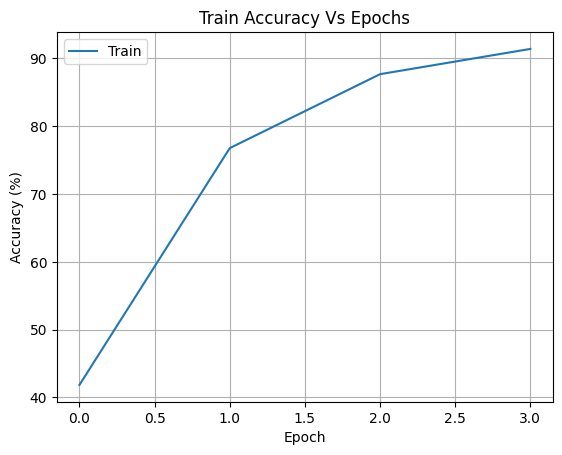

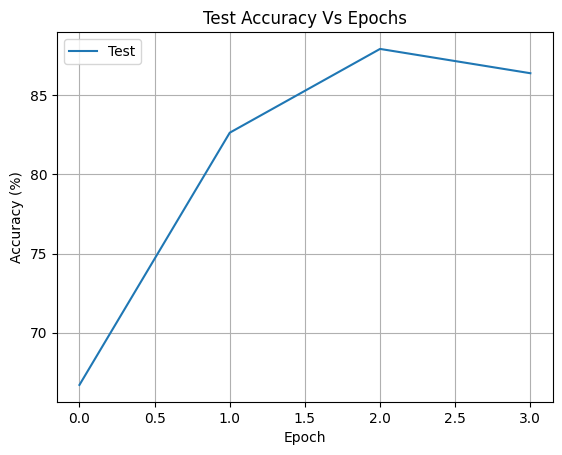

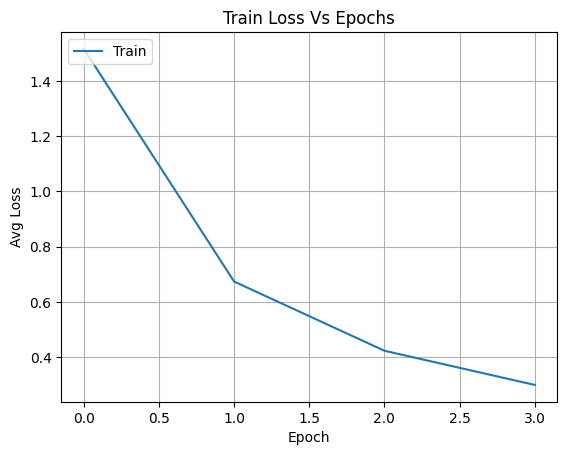

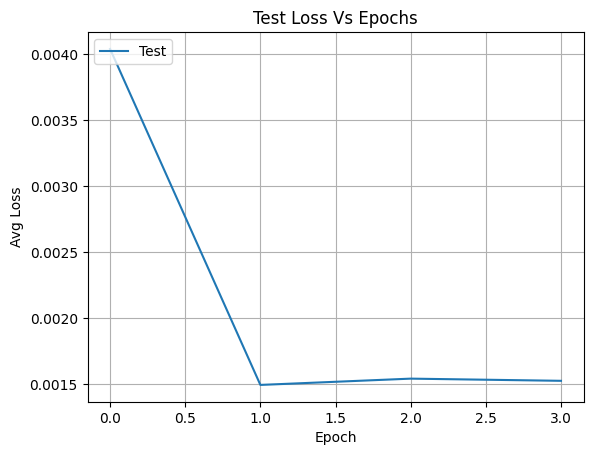


Pseudo-Labelling


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Post Pseudo-Labelling Classification
Epoch 1/4, Train Loss: 1.9288, Train Acc: 24.64%, Val Loss: 0.0045, Val Acc: 48.32%
Epoch 2/4, Train Loss: 0.8772, Train Acc: 69.94%, Val Loss: 0.0012, Val Acc: 83.80%
Epoch 3/4, Train Loss: 0.4171, Train Acc: 87.83%, Val Loss: 0.0007, Val Acc: 88.48%
Epoch 4/4, Train Loss: 0.2853, Train Acc: 92.10%, Val Loss: 0.0021, Val Acc: 80.62%



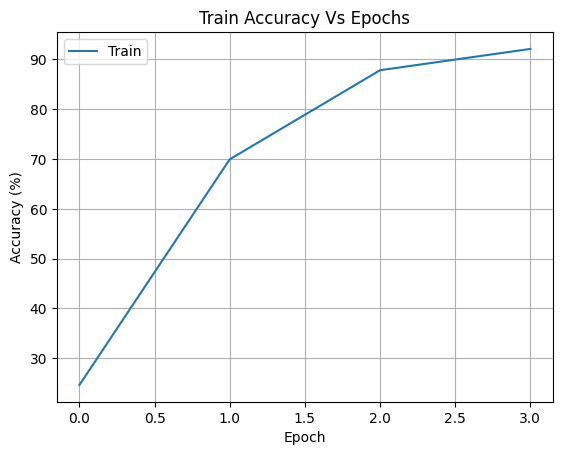

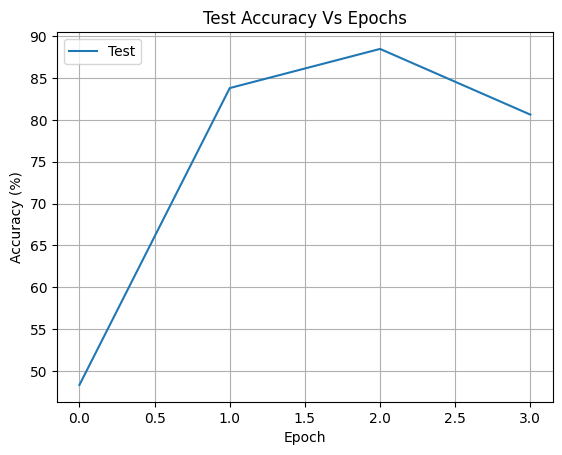

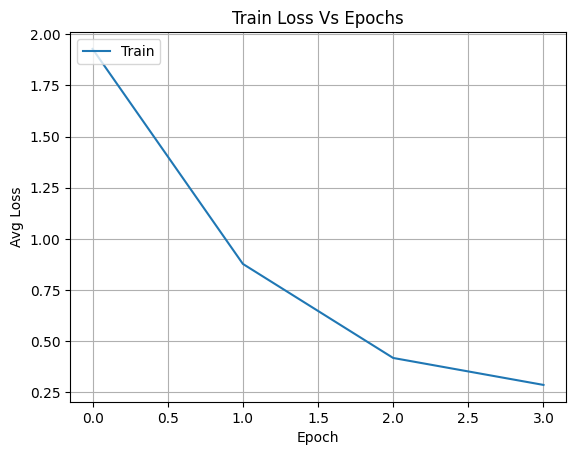

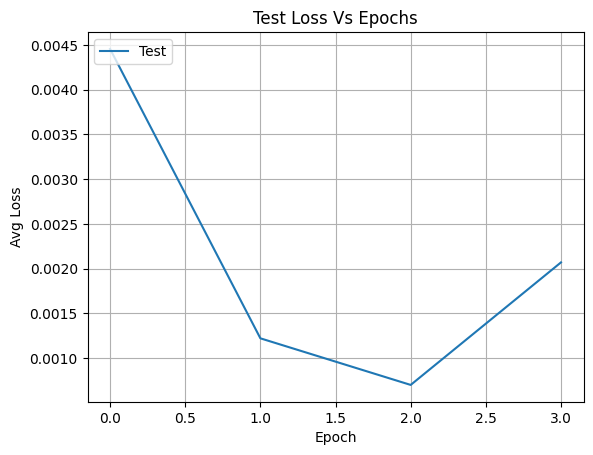

In [16]:
semi_supervised(.8)

Pre Pseudo-Labelling Classification
Epoch 1/4, Train Loss: 1.9464, Train Acc: 26.45%, Val Loss: 0.0070, Val Acc: 25.07%
Epoch 2/4, Train Loss: 1.3249, Train Acc: 46.21%, Val Loss: 0.0029, Val Acc: 65.84%
Epoch 3/4, Train Loss: 0.9371, Train Acc: 65.80%, Val Loss: 0.0032, Val Acc: 63.07%
Epoch 4/4, Train Loss: 0.6366, Train Acc: 79.69%, Val Loss: 0.0026, Val Acc: 83.48%



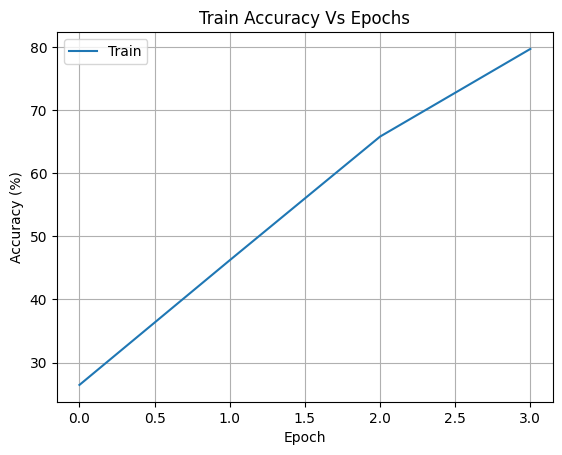

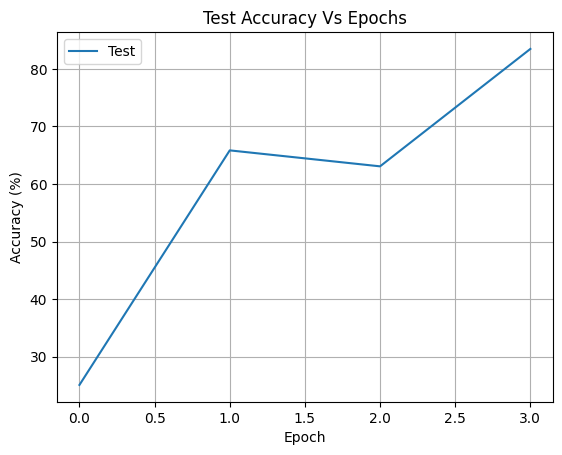

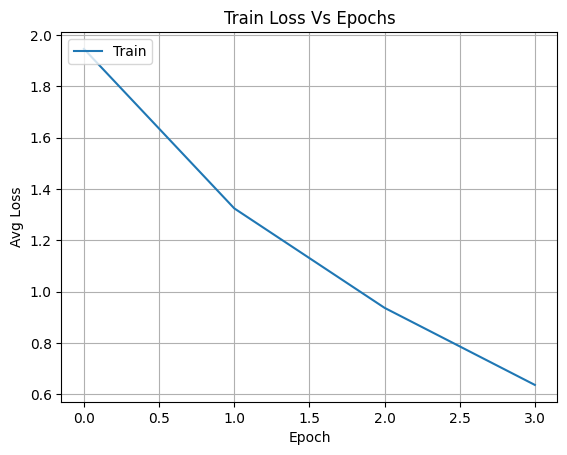

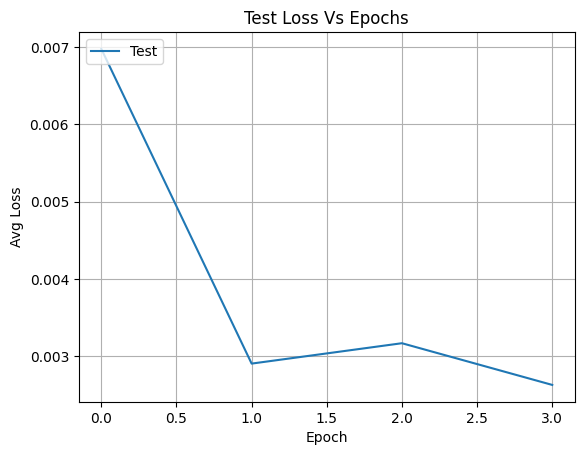


Pseudo-Labelling


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Post Pseudo-Labelling Classification
Epoch 1/4, Train Loss: 1.7473, Train Acc: 31.06%, Val Loss: 0.0037, Val Acc: 54.94%
Epoch 2/4, Train Loss: 0.7447, Train Acc: 74.45%, Val Loss: 0.0030, Val Acc: 78.79%
Epoch 3/4, Train Loss: 0.3727, Train Acc: 89.50%, Val Loss: 0.0008, Val Acc: 90.30%
Epoch 4/4, Train Loss: 0.2683, Train Acc: 92.81%, Val Loss: 0.0013, Val Acc: 91.77%



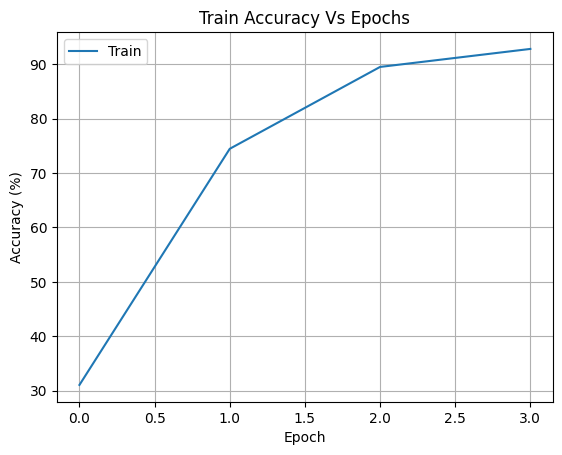

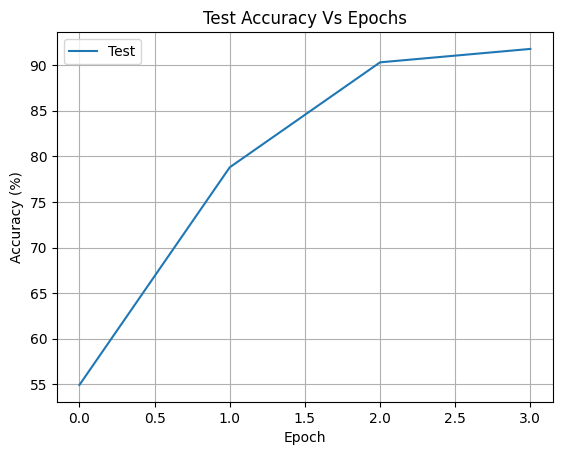

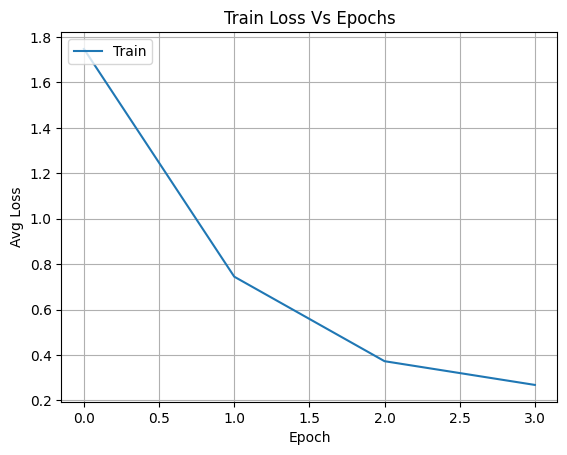

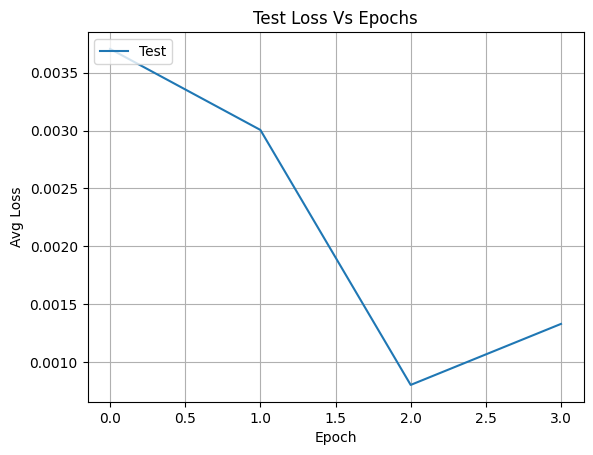

In [17]:
semi_supervised(.4)

Pre Pseudo-Labelling Classification
Epoch 1/4, Train Loss: 2.3443, Train Acc: 14.80%, Val Loss: 0.0078, Val Acc: 16.33%
Epoch 2/4, Train Loss: 1.8589, Train Acc: 24.57%, Val Loss: 0.0068, Val Acc: 27.34%
Epoch 3/4, Train Loss: 1.6325, Train Acc: 34.87%, Val Loss: 0.0053, Val Acc: 36.41%
Epoch 4/4, Train Loss: 1.4929, Train Acc: 41.57%, Val Loss: 0.0051, Val Acc: 47.27%



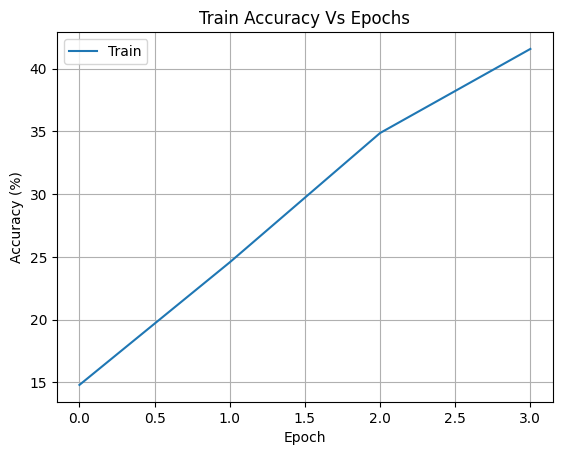

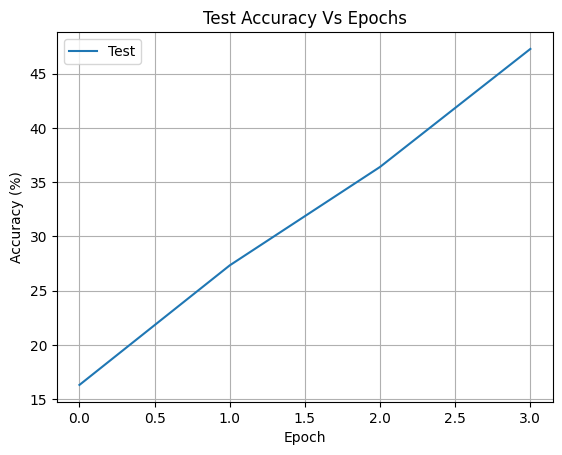

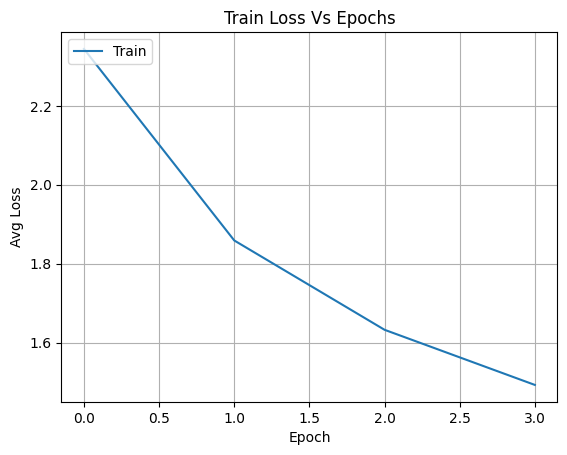

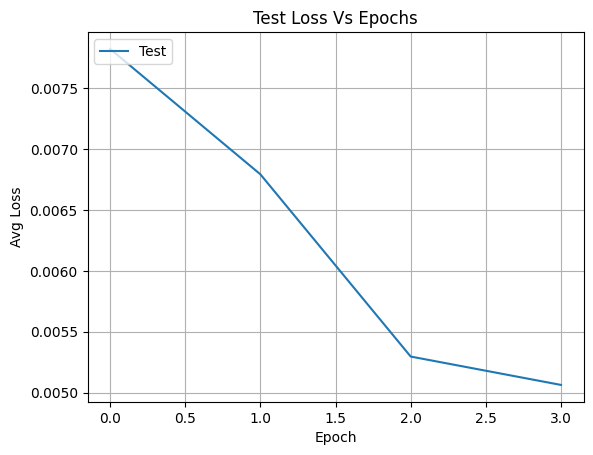


Pseudo-Labelling


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Post Pseudo-Labelling Classification
Epoch 1/4, Train Loss: 1.7612, Train Acc: 32.50%, Val Loss: 0.0051, Val Acc: 58.45%
Epoch 2/4, Train Loss: 0.7180, Train Acc: 75.13%, Val Loss: 0.0018, Val Acc: 81.86%
Epoch 3/4, Train Loss: 0.3842, Train Acc: 89.07%, Val Loss: 0.0020, Val Acc: 90.59%
Epoch 4/4, Train Loss: 0.2639, Train Acc: 92.81%, Val Loss: 0.0006, Val Acc: 89.91%



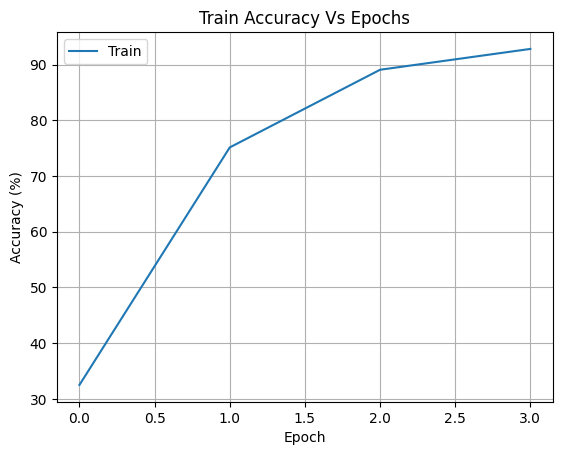

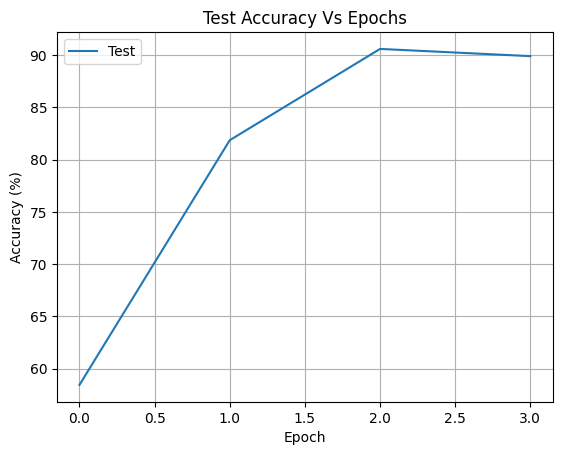

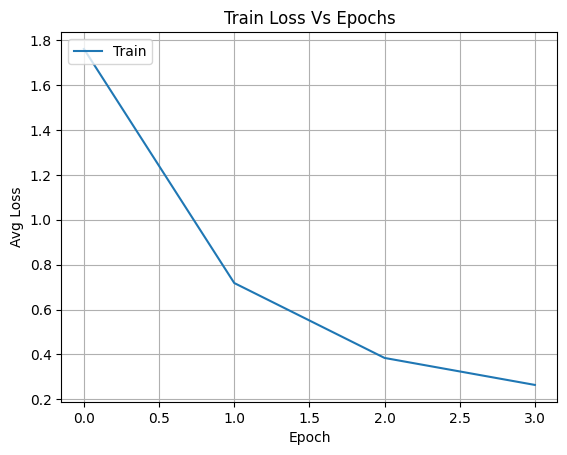

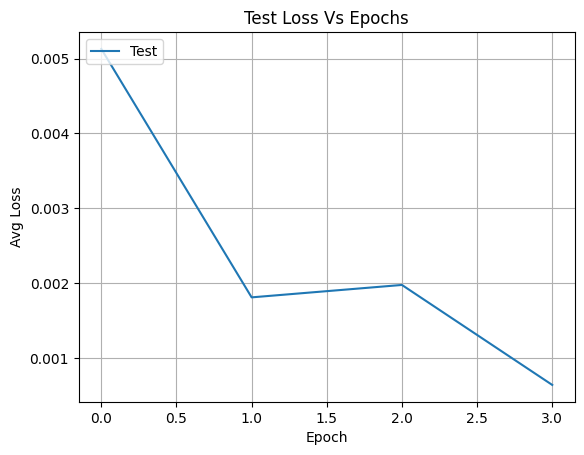

In [18]:
semi_supervised(.1)

## Conclusion

In this experiment on the MNIST dataset, we employed a semi-supervised learning approach using pseudo-labeling to leverage unlabeled data. Initially, we applied K-means clustering to the unlabeled data, utilizing the deep features extracted by a CNN model. Specifically, we chose the VGG16 architecture, renowned for its ability to unearth profound insights into data through deep feature extraction. Following the clustering, we used the K-Nearest Neighbors (KNN) algorithm to assign labels to each cluster by employing a majority vote from the labels of the nearest labeled points.

The integration of CNN with VGG16 enabled us to delve deeper into the intrinsic patterns within the images, significantly enhancing our clustering and pseudo-labeling processes. It became evident that the inclusion of more labeled data progressively augmented the effectiveness of the K-means and KNN algorithms on both training and test accuracies. A notable observation was made when 80% of the data was labeled; the model trained solely on labeled data was sufficiently accurate on the test data. However, as we reduced the labeled data to 40% and further down to 10%, the performance on test data markedly deteriorated. This deterioration was effectively countered by the pseudo-labeling of the unlabeled data and subsequent retraining. This approach yielded a substantial improvement in test accuracy, nearly reaching 90%. The experiment thus underscores the vital role of pseudo-labeling in bolstering the performance of neural networks under conditions of sparse labeled data, demonstrating the robustness of semi-supervised learning especially when unlabeled data predominates.

To further enhance the model’s robustness and ensure its applicability to real-world scenarios, we incorporated data augmentation techniques such as Gaussian blur, noise addition, rotations, and flips. This not only helped the model generalize better but also achieved impressive accuracy on augmented test data. The augmentation mirrored practical image variations, thereby preparing the model for effective deployment in diverse settings.

However, the experiment was not without its challenges. The primary limitation was the capacity of available computational resources, specifically memory and GPU capabilities, which restricted us to a subset of the MNIST dataset. The random selection of data and augmentation methods also posed constraints, potentially skewing the distribution and impact of our training set. To mitigate these limitations and enhance the efficiency of our training process, we considered advanced strategies such as bagging, boosting, and optimizing hyperparameters like learning rate and batch sizes.

Looking ahead, the integration of more sophisticated models such as Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs) could offer significant improvements. These models provide a framework for understanding more complex distributions within the data—key for tackling datasets more intricate than MNIST, such as CIFAR100.

In conclusion, this experiment not only validated the efficacy of semi-supervised learning in handling limited labeled data but also highlighted the transformative potential of advanced neural network models and data augmentation in adapting to real-world complexities.
